In [55]:
!pip show lightgbm


Name: lightgbm
Version: 4.3.0
Summary: LightGBM Python Package
Home-page: https://github.com/microsoft/LightGBM
Author: 
Author-email: 
License: The MIT License (MIT)

Copyright (c) Microsoft Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS O

In [56]:
import os
os.environ['DISPLAY'] = ':0.0'  # Set the DISPLAY environment variable to the default display


In [57]:
!pip install lightgbm

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from lightgbm import LGBMClassifier

In [59]:
# Load the data
train_data = pd.read_csv('train.csv')

In [60]:
# Display the first few rows of the DataFrame
train_data.head(10)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
5,5,Male,18.128249,1.748524,51.552595,yes,yes,2.919751,3.000000,Sometimes,no,2.137550,no,1.930033,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
6,6,Male,29.883021,1.754711,112.725005,yes,yes,1.991240,3.000000,Sometimes,no,2.000000,no,0.000000,0.696948,Sometimes,Automobile,Obesity_Type_II
7,7,Male,29.891473,1.750150,118.206565,yes,yes,1.397468,3.000000,Sometimes,no,2.000000,no,0.598655,0.000000,Sometimes,Automobile,Obesity_Type_II
8,8,Male,17.000000,1.700000,70.000000,no,yes,2.000000,3.000000,Sometimes,no,3.000000,yes,1.000000,1.000000,no,Public_Transportation,Overweight_Level_I
9,9,Female,26.000000,1.638836,111.275646,yes,yes,3.000000,3.000000,Sometimes,no,2.632253,no,0.000000,0.218645,Sometimes,Public_Transportation,Obesity_Type_III


In [61]:
# Check for missing values
train_data.isnull().sum()

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [62]:
# Check for duplicated values

duplicates = train_data.duplicated()

# Count the number of duplicated rows
num_duplicates = duplicates.sum()

print("Number of duplicated rows:", num_duplicates)


Number of duplicated rows: 0


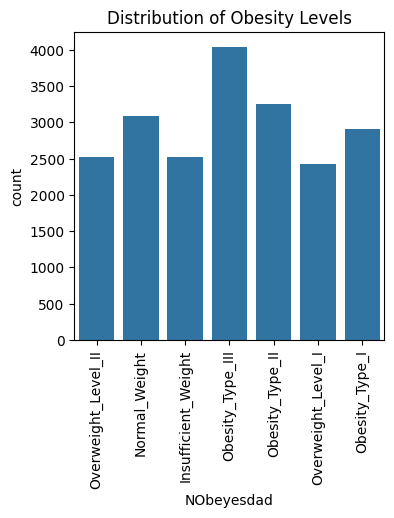

In [63]:
# Visualize the distribution of the target variable (NObeyesdad)

plt.figure(figsize=(4, 4))
sns.countplot(x='NObeyesdad', data=train_data)
plt.title('Distribution of Obesity Levels')
plt.xticks(rotation=90)
plt.show()


In [64]:
# Encode target variable into numerical labels
label_encoder = LabelEncoder()
train_data['NObeyesdad'] = label_encoder.fit_transform(train_data['NObeyesdad'])

In [65]:
# Split features and target variable

X = train_data.drop(columns=['NObeyesdad'])
y = train_data['NObeyesdad']


In [66]:
# Define categorical and numerical features

categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [67]:
# Split the data into training and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [69]:
# Define the LGBM model
lgbm_model = LGBMClassifier()


In [70]:
# Define the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', lgbm_model)])


In [71]:
# Define hyperparameters for randomized search
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],
    'classifier__max_depth': [3, 5, 7, 9, 11],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__subsample': [0.5, 0.7, 0.9, 1.0],
    'classifier__colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'classifier__min_child_samples': [10, 20, 30, 40, 50],
    'classifier__reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'classifier__reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'classifier__min_child_weight': [1e-3, 1e-2, 0.1, 1, 10]
}

In [72]:
# Perform randomized search cross-validation

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=3, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 30
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
[LightGBM] [Info] Start training from score -2.145531
[

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Height',
                                                                                'Weight',
                                                                                'FCVC',
                                                                                'NCP',
                                                                                'CH2O',
                                                                                'FAF',
                                                                                'TUE']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Gender',
                                                                                'family_history_with_overweight',
                                                                                'FAVC',
                                                                                'CAEC',
                                                                                'SMOKE',...
                                                                      0.2,
                                                                      0.3],
                                        'classifier__max_depth': [3, 5, 7, 9,
                                                                  11],
                                        'classifier__min_child_samples': [10,
                                                                          20,
                                                                          30,
                                                                          40,
                                                                          50],
                                        'classifier__min_child_weight': [0.001,
                                                                         0.01,
                                                                         0.1, 1,
                                                                         10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300, 400,
                                                                     500],
                                        'classifier__reg_alpha': [0.0, 0.1, 0.5,
                                                                  1.0],
                                        'classifier__reg_lambda': [0.0, 0.1,
                                                                   0.5, 1.0],
                                        'classifier__subsample': [0.5, 0.7, 0.9,
                                                                  1.0]},
                   random_state=42, verbose=2)

In [73]:
# Get the best parameters

best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [74]:
# Print the best parameters
print("Best Parameters:", best_params)

Best Parameters: {'classifier__subsample': 0.7, 'classifier__reg_lambda': 1.0, 'classifier__reg_alpha': 1.0, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 0.001, 'classifier__min_child_samples': 20, 'classifier__max_depth': 9, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.5}


In [75]:
# Evaluate the best model on the validation set
accuracy = best_model.score(X_test, y_test)
print("Validation Accuracy:", accuracy)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Validation Accuracy: 0.9092003853564548


In [76]:
# best model on entire dataset
best_model.fit(X,y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2045
[LightGBM] [Info] Number of data points in the train set: 20758, number of used features: 30
[LightGBM] [Info] Start training from score -2.107483
[LightGBM] [Info] Start training from score -1.907353
[LightGBM] [Info] Start training from score -1.964779
[LightGBM] [Info] Start training from score -1.854892
[LightGBM] [Info] Start training from score -1.635203
[LightGBM] [Info] Start training from score -2.146276
[LightGBM] [Info] Start training from score -2.107879
[LightGBM

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Height', 'Weight',
                                                   'FCVC', 'NCP', 'CH2O', 'FAF',
                                                   'TUE']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'CAEC', 'SMOKE',
                                                   'SCC', 'CALC',
                                                   'MTRANS'])])),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.5, learning_rate=0.05,
                                max_depth=9, n_estimators=200, reg_alpha=1.0,
                                reg_lambda=1.0, subsample=0.7))])

In [77]:
# Prepare test data

test_data = pd.read_csv('test.csv')

In [78]:
# Make predictions on test data
test_predictions = best_model.predict(test_data)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [79]:
# Create submission dataframe
""""
submission_df = pd.DataFrame({'id': test_data['id'], 
                              'NObeyesdad': label_encoder.inverse_transform(test_predictions)})
                              """

'"\nsubmission_df = pd.DataFrame({\'id\': test_data[\'id\'], \n                              \'NObeyesdad\': label_encoder.inverse_transform(test_predictions)})\n                              '

In [80]:
# Save submission dataframe to CSV
""""
submission_df.to_csv('submission.csv', index=False)
"""

'"\nsubmission_df.to_csv(\'submission.csv\', index=False)\n'

In [81]:
import joblib

In [82]:
from joblib import dump

In [83]:

joblib.dump(best_model,'trained_model')


['trained_model']

In [90]:

joblib.dump(label_encoder,'label_encoder')


['label_encoder']

In [89]:
import os
print("Current working directory:", os.getcwd())


Current working directory: c:\Users\202012529\Desktop\django1\Notebooks


In [91]:
#joblib.dump(label_encoder,'./../SavedModels/label_encoder.joblib')

['./../SavedModels/label_encoder.joblib']

In [86]:
dump(best_model, "./../SavedModels/best_model.joblib")

['./../SavedModels/best_model.joblib']

In [87]:
""""
import tkinter as tk
from tkinter import ttk
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import joblib

# Load the label encoder for the target variable
label_encoder = LabelEncoder()
label_encoder.classes_ = pd.read_pickle('label_encoder')

# Load the saved model
best_model = joblib.load('trained_model')

def predict_obesity():
    # Get user input
    gender = gender_var.get()
    age = float(age_entry.get())
    height = float(height_entry.get())
    weight = float(weight_entry.get())
    family_history = family_history_var.get()
    favc = favc_var.get()
    fcvc = float(fcvc_entry.get())
    ncp = float(ncp_entry.get())
    caec = caec_var.get()
    smoke = smoke_var.get()
    ch2o = float(ch2o_entry.get())
    scc = scc_var.get()
    faf = float(faf_entry.get())
    tue = float(tue_entry.get())
    calc = calc_var.get()
    mtrans = mtrans_var.get()

    # Prepare input data
    data = pd.DataFrame({
        'Gender': [gender],
        'Age': [age],
        'Height': [height],
        'Weight': [weight],
        'family_history_with_overweight': [family_history],
        'FAVC': [favc],
        'FCVC': [fcvc],
        'NCP': [ncp],
        'CAEC': [caec],
        'SMOKE': [smoke],
        'CH2O': [ch2o],
        'SCC': [scc],
        'FAF': [faf],
        'TUE': [tue],
        'CALC': [calc],
        'MTRANS': [mtrans]
    })

    # Make prediction using the loaded model
    prediction = best_model.predict(data)
    result_label.config(text="Predicted obesity level: {}".format(label_encoder.inverse_transform(prediction)[0]))

"""

'"\nimport tkinter as tk\nfrom tkinter import ttk\nimport pandas as pd\nfrom sklearn.preprocessing import LabelEncoder\nimport joblib\n\n# Load the label encoder for the target variable\nlabel_encoder = LabelEncoder()\nlabel_encoder.classes_ = pd.read_pickle(\'label_encoder\')\n\n# Load the saved model\nbest_model = joblib.load(\'trained_model\')\n\ndef predict_obesity():\n    # Get user input\n    gender = gender_var.get()\n    age = float(age_entry.get())\n    height = float(height_entry.get())\n    weight = float(weight_entry.get())\n    family_history = family_history_var.get()\n    favc = favc_var.get()\n    fcvc = float(fcvc_entry.get())\n    ncp = float(ncp_entry.get())\n    caec = caec_var.get()\n    smoke = smoke_var.get()\n    ch2o = float(ch2o_entry.get())\n    scc = scc_var.get()\n    faf = float(faf_entry.get())\n    tue = float(tue_entry.get())\n    calc = calc_var.get()\n    mtrans = mtrans_var.get()\n\n    # Prepare input data\n    data = pd.DataFrame({\n        \'Gende

In [88]:
""""
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import joblib

# Function to load the trained model and perform prediction
def predict_and_save():
    # Load the trained model
    try:
        trained_model = joblib.load('trained_model')
    except FileNotFoundError:
        messagebox.showerror("Error", "Model not found. Please train a model first.")
        return
    
    # Browse for test data file
    file_path = filedialog.askopenfilename()
    if not file_path:
        messagebox.showerror("Error", "Please select a file.")
        return
    
    try:
        # Load the test data
        test_data = pd.read_csv(file_path)
        
        # Make predictions
        test_predictions = trained_model.predict(test_data)
        
        # Load the label encoder
        label_encoder = joblib.load('label_encoder')
        
        # Convert numerical labels back to original categories
        #predicted_categories = label_encoder.inverse_transform(predictions)
        
        # Create submission dataframe
        #submission_df = pd.DataFrame({'id': range(1, len(predicted_categories) + 1), 'NObeyesdad': predicted_categories})
        submission_df = pd.DataFrame({'id': test_data['id'], 
                'NObeyesdad': label_encoder.inverse_transform(test_predictions)})
        # Save submission dataframe to CSV
        submission_df.to_csv('submission.csv', index=False)
        
        messagebox.showinfo("Predictions", "Predictions have been made and saved as 'submission.csv'.")
    except Exception as e:
        messagebox.showerror("Error", f"An error occurred: {str(e)}")
"""

'"\nimport tkinter as tk\nfrom tkinter import filedialog, messagebox\nimport pandas as pd\nimport joblib\n\n# Function to load the trained model and perform prediction\ndef predict_and_save():\n    # Load the trained model\n    try:\n        trained_model = joblib.load(\'trained_model\')\n    except FileNotFoundError:\n        messagebox.showerror("Error", "Model not found. Please train a model first.")\n        return\n    \n    # Browse for test data file\n    file_path = filedialog.askopenfilename()\n    if not file_path:\n        messagebox.showerror("Error", "Please select a file.")\n        return\n    \n    try:\n        # Load the test data\n        test_data = pd.read_csv(file_path)\n        \n        # Make predictions\n        test_predictions = trained_model.predict(test_data)\n        \n        # Load the label encoder\n        label_encoder = joblib.load(\'label_encoder\')\n        \n        # Convert numerical labels back to original categories\n        #predicted_catego